In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import glob as gb
import cv2
import PIL
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow import keras
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainpath = '/content/drive/My Drive/Cancer Cells/train'
testpath = '/content/drive/My Drive/Cancer Cells/test'

In [ ]:
new_size=224
train_images=[]
train_labels=[]
for i in os.listdir(trainpath):#entering train folder
  print("Entering to the folder name:",i)
  files=gb.glob(pathname=str(trainpath+'/' + i + '/*.jpg'))# pointing to all the .jpg extension image folder
  print("Number of images in the folder is",len(files))
  for j in files:# reading each images
      class_cancer={'benign':0,'malignant':1}
      image_raw=cv2.imread(j)
      image=cv2.cvtColor(image_raw,cv2.COLOR_BGR2RGB)
      resize_image=cv2.resize(image,(new_size,new_size))
      train_images.append(list(resize_image))
      train_labels.append(class_cancer[i])

Entering to the folder name: .DS_Store
Number of images in the folder is 0
Entering to the folder name: malignant
Number of images in the folder is 25
Entering to the folder name: benign
Number of images in the folder is 25


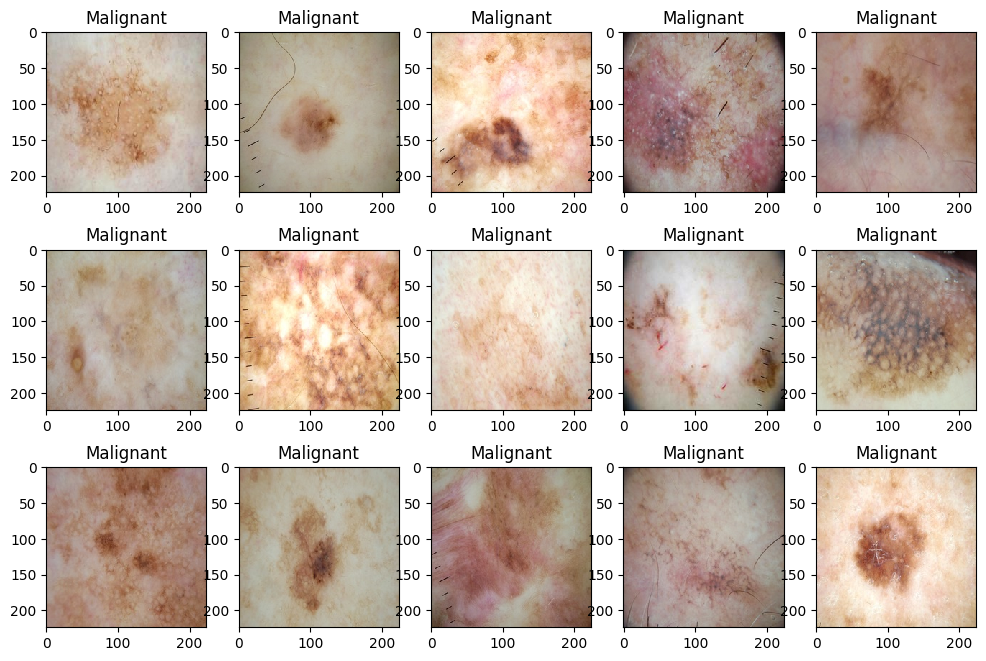

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if train_labels[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(train_images[i], interpolation='nearest')
plt.show()

In [ ]:
new_size=224
test_images=[]
test_labels=[]
for i in os.listdir(testpath):# entering to the test folder
  print("Entering to the folder name:",i)
  files=gb.glob(pathname=str(testpath +'/' + i + '/*.jpg'))# pointing to all the .jpg extension image folder
  print("Number of images in the folder is",len(files))
  for j in files:
      class_cancer={'benign':0,'malignant':1}
      image_raw=cv2.imread(j)
      image=cv2.cvtColor(image_raw,cv2.COLOR_BGR2RGB)
      resize_image=cv2.resize(image,(new_size,new_size))
      test_images.append(list(resize_image))
      test_labels.append(class_cancer[i])


Entering to the folder name: .DS_Store
Number of images in the folder is 0
Entering to the folder name: benign
Number of images in the folder is 25
Entering to the folder name: malignant
Number of images in the folder is 25


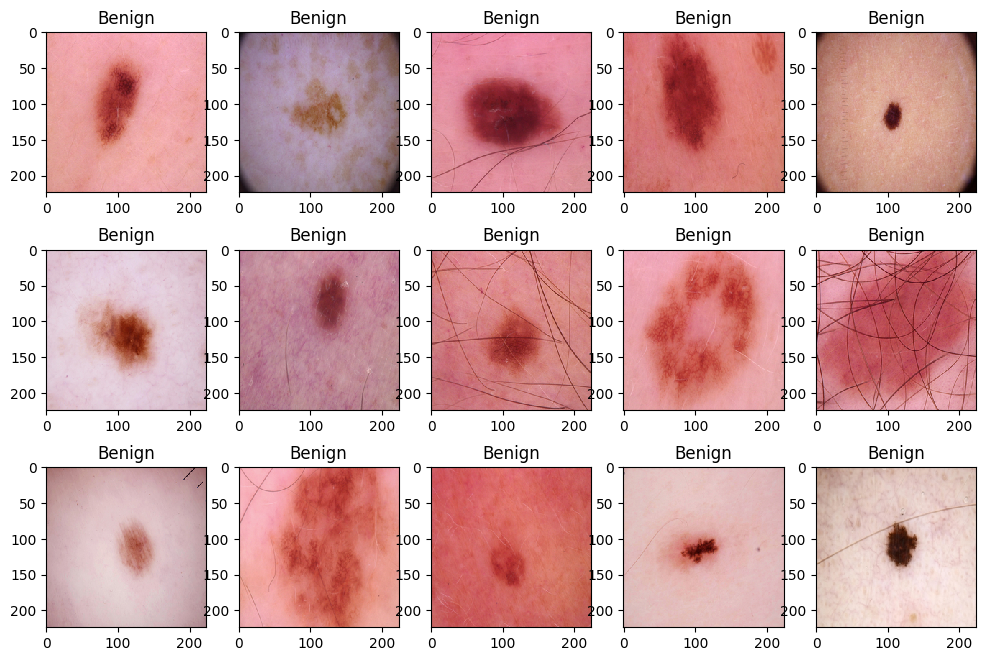

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if test_labels[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(test_images[i], interpolation='nearest')
plt.show()

In [ ]:
def list_to_array_train(train_images,train_labels):
  return np.array(train_images),np.array(train_labels)

X_train,y_train=list_to_array_train(train_images,train_labels)


def list_to_array_test(test_images,test_labels):
  return np.array(test_images),np.array(test_labels)


X_test,y_test=list_to_array_test(test_images,test_labels)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(50, 224, 224, 3)
(50,)
(50, 224, 224, 3)
(50,)


In [ ]:
def keras_to_categorical(y_train,y_test):
  return to_categorical(y_train),to_categorical(y_test)
y_train1=y_train
y_test1=y_test
y_train,y_test=keras_to_categorical(y_train,y_test)

In [ ]:
y_train1.shape,y_test1.shape

((50,), (50,))

In [139]:
def model_vgg16():#cnn model #imagenet dataset given
  VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
  #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
  for layer in VGG_model.layers:
    layer.trainable = False #True for actual transfer learning
  feature=keras.layers.GlobalAveragePooling2D()(VGG_model.output)
  d1=Dense(units=64,kernel_initializer="glorot_uniform", activation='relu')(feature)
  d2=Dense(units=32,kernel_initializer="glorot_uniform", activation='softmax')(d1)
  d3=Dense(units=2,kernel_initializer="glorot_uniform", activation='softmax')(d2)
  output = Model(inputs =VGG_model.input, outputs =d3)
  #output = Model(inputs =VGG_model.input, outputs =feature)

  return output

model16=model_vgg16()

In [140]:
model16.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

In [141]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Print messages when stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Train the model with EarlyStopping callback
history = model16.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=5,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 76s 8s/step - accuracy: 0.4617 - loss: 0.2444 - val_accuracy: 0.6200 - val_loss: 0.2270
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - accuracy: 0.7251 - loss: 0.2050 - val_accuracy: 0.8200 - val_loss: 0.2019
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.9399 - loss: 0.1889 - val_accuracy: 0.8200 - val_loss: 0.1939
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 95s 8s/step - accuracy: 0.9749 - loss: 0.1629 - val_accuracy: 0.8000 - val_loss: 0.1847
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - accuracy: 0.9526 - loss: 0.1539 - val_accuracy: 0.8200 - val_loss: 0.1872
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.9722 - loss: 0.1495 - val_accuracy: 0.8400 - val_loss: 0.1770
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 1.0000 - loss: 0.1336 - val_accuracy: 0.8600 - val_loss: 0.1676
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 72s 8s/step - accuracy: 1.0000 - loss: 0.1285 - val_accuracy: 0.8600 - val_loss:

In [142]:
test_loss, test_accuracy = model16.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 12s/step - accuracy: 0.8888 - loss: 0.1529
Test Accuracy: 0.8799999952316284


In [143]:
def model_vgg19():
  VGG19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))
  #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
  for layer in VGG19_model.layers:
    layer.trainable = False #True for actual transfer learning
  feature=keras.layers.GlobalAveragePooling2D()(VGG19_model.output)
  d1=Dense(units=64,kernel_initializer="glorot_uniform", activation='relu')(feature)
  d2=Dense(units=32,kernel_initializer="glorot_uniform", activation='softmax')(d1)
  d3=Dense(units=2,kernel_initializer="glorot_uniform", activation='sigmoid')(d2)
  output = Model(inputs =VGG19_model.input, outputs =d3)
  #output = Model(inputs =VGG_model.input, outputs =feature)

  return output

model19=model_vgg19()

In [144]:
model19.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

In [145]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Print messages when stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Train the model with EarlyStopping callback
history = model19.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=5,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 85s 9s/step - accuracy: 0.6130 - loss: 0.2486 - val_accuracy: 0.6600 - val_loss: 0.2401
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - accuracy: 0.8103 - loss: 0.2286 - val_accuracy: 0.7600 - val_loss: 0.2290
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.9334 - loss: 0.2108 - val_accuracy: 0.7800 - val_loss: 0.2091
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - accuracy: 0.9631 - loss: 0.1869 - val_accuracy: 0.7800 - val_loss: 0.2073
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 85s 9s/step - accuracy: 1.0000 - loss: 0.1783 - val_accuracy: 0.8400 - val_loss: 0.1972
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 1.0000 - loss: 0.1720 - val_accuracy: 0.8800 - val_loss: 0.1934
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 121s 13s/step - accuracy: 1.0000 - loss: 0.1700 - val_accuracy: 0.8400 - val_loss: 0.1979
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 8s/step - accuracy: 1.0000 - loss: 0.1655 - val_accuracy: 0.8200 - val_

In [146]:
test_loss, test_accuracy = model19.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 18s/step - accuracy: 0.8308 - loss: 0.1947
Test Accuracy: 0.8399999737739563
